---
bibliography:
  - bibliography.bib
---

# Linear Model Selection

### Linear Model Selection Example 2.1
For the  **Credit** example, we begin with the so-called *null model* $ \mathcal{M}_{0} $, which contains no predictors:
\begin{equation*}
balance
=\beta_{0}+\epsilon
\end{equation*}
Then, we add a predictor variable to the null model. 
For this example, we will write two **Python**-functions, one to fit a linear model and return important scoring metrics and one to add one predictor to a model, based on the returned scores. 

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load data
df = pd.read_csv('Linear Model Selection/data/Credit.csv')

# Convert Categorical variables
df = pd.get_dummies(data=df, drop_first=True, 
                    prefix=('Gender_', 'Student_', 
                            'Married_', 'Ethnicity_'))

x_full = df.drop(columns='Balance')
y = df['Balance']


def fit_linear_reg(x, y):
    '''Fit Linear model with predictors x on y 
    return AIC, BIC, R2 and R2 adjusted '''
    x = sm.add_constant(x)
    # Create and fit model
    model_k = sm.OLS(y, x).fit()
    
    # Find scores
    BIC = model_k.bic
    AIC = model_k.aic
    R2 = model_k.rsquared
    R2_adj = model_k.rsquared_adj
    RSS = model_k.ssr
    
    # Return result in Series
    results = pd.Series(data={'BIC': BIC, 'AIC': AIC, 'R2': R2,
                              'R2_adj': R2_adj, 'RSS': RSS})
    
    return results


def add_one(x_full, x, y, scoreby='RSS'):
    ''' Add possible predictors from x_full to x, 
    Fit a linear model on y using fit_linear_reg
    Returns Dataframe showing scores as well as best model '''
    # Predefine DataFrame
    x_labels = x_full.columns
    zeros = np.zeros(len(x_labels))
    results = pd.DataFrame(
        data={'Predictor': x_labels.values, 'BIC': zeros, 
               'AIC': zeros, 'R2': zeros, 
               'R2_adj': zeros, 'RSS': zeros})

    # For every predictor find R^2, RSS, and AIC
    for i in range(len(x_labels)):
        x_i = np.concatenate((x, [np.array(x_full[x_labels[i]])]))
        results.iloc[i, 1:] = fit_linear_reg(x_i.T, y)
        
    # Depending on where we scoreby, we select the highest or lowest
    if scoreby in ['RSS', 'AIC', 'BIC']:
        best = x_labels[results[scoreby].argmin()]
    elif scoreby in ['R2', 'R2_adj']:
        best = x_labels[results[scoreby].argmax()]
        
    return results, best 


# Define the empty predictor
x_empty = [np.zeros(len(y))]

results, best1 = add_one(x_full, x_empty, y)

print(results[['Predictor', 'AIC', 'R2', 'RSS']], 
      '\n\nBest predictor is:',  best1)

               Predictor          AIC        R2           RSS
0             Unnamed: 0  6042.696603  0.000037  8.433681e+07
1                 Income  5945.894250  0.214977  6.620874e+07
2                  Limit  5499.982633  0.742522  2.171566e+07
3                 Rating  5494.781548  0.745848  2.143512e+07
4                  Cards  6039.710202  0.007475  8.370950e+07
5                    Age  6042.709965  0.000003  8.433963e+07
6              Education  6042.685316  0.000065  8.433443e+07
7         Gender__Female  6042.526817  0.000461  8.430102e+07
8           Student__Yes  6014.932656  0.067090  7.868154e+07
9           Married__Yes  6042.698437  0.000032  8.433720e+07
10      Ethnicity__Asian  6042.672799  0.000096  8.433179e+07
11  Ethnicity__Caucasian  6042.706987  0.000011  8.433900e+07 

Best predictor is: Rating


We will save the definition used in a helper file, **LMS_def.py**.

We now choose the *best* variable in the sense that adding this variable leads to the regression model with the lowest RSS or the highest $ R^2 $. The variable that results in the model with the lowest RSS is in this case **rating**. 

Thus, we have found the model $ \mathcal{M}_{1} $
\begin{equation*}
balance
=\beta_{0}+\beta_{1}\cdot rating +\epsilon
\end{equation*}


We now add a further predictor variable to this model by first updating the reference model and removing the chosen predictor from the set of possible predictors. Subsequently, we can run the same procedure and decide which predictor variable to add next.

In [2]:
# Update the empty predictor with the best predictor
x_1 = [df[best1]]
# Remove the chosen predictor from the list of options
x_red = x_full.drop(columns=best1, errors='ignore')

results, best2 = add_one(x_red, x_1, y)

print(results[['Predictor', 'AIC', 'R2', 'RSS']], 
      '\n\nBest predictor is:',  best2)

               Predictor          AIC        R2           RSS
0             Unnamed: 0  5496.518489  0.746016  2.142103e+07
1                 Income  5212.557085  0.875118  1.053254e+07
2                  Limit  5496.632982  0.745943  2.142716e+07
3                  Cards  5494.187124  0.747492  2.129654e+07
4                    Age  5484.481339  0.753545  2.078601e+07
5              Education  5496.272851  0.746171  2.140788e+07
6         Gender__Female  5496.481640  0.746039  2.141906e+07
7           Student__Yes  5372.232473  0.813849  1.569996e+07
8           Married__Yes  5494.569548  0.747250  2.131691e+07
9       Ethnicity__Asian  5496.067431  0.746302  2.139689e+07
10  Ethnicity__Caucasian  5496.772749  0.745854  2.143465e+07 

Best predictor is: Income


We select again the variable that leads when added to the reference model to the lowest RSS. In this case, we select the predictor variable **income** which gives us the model $ \mathcal{M}_2 $:
\begin{equation*}
balance
=\beta_{0}+\beta_{1}\cdot rating+\beta_{2}\cdot income +\epsilon
\end{equation*}

This procedure will be repeated. In particular, we will add one variable among the 
remaining $ p - 2 $ variables to the model $ \mathcal{M}_{2} $. The resulting model with the lowest RSS will become model $ \mathcal{M}_{3} $.

In [3]:
# Update the empty predictor with the best predictor
x_2 = np.concatenate((x_1, [df[best2]]))
# Remove the chosen predictor from the list of options
x_red = x_red.drop(columns=best2, errors='ignore')

results, best3 = add_one(x_red, x_2, y)

print(results[['Predictor', 'AIC', 'R2', 'RSS']], 
      '\n\nBest predictor is:',  best3)

              Predictor          AIC        R2           RSS
0            Unnamed: 0  5214.551863  0.875120  1.053240e+07
1                 Limit  5210.950291  0.876239  1.043800e+07
2                 Cards  5214.477534  0.875143  1.053045e+07
3                   Age  5211.113461  0.876188  1.044226e+07
4             Education  5213.765645  0.875365  1.051172e+07
5        Gender__Female  5214.521087  0.875129  1.053159e+07
6          Student__Yes  4849.386992  0.949879  4.227219e+06
7          Married__Yes  5210.930247  0.876245  1.043747e+07
8      Ethnicity__Asian  5212.042074  0.875901  1.046653e+07
9  Ethnicity__Caucasian  5213.976405  0.875299  1.051726e+07 

Best predictor is: Student__Yes


We can automatically select the n-best predictors using SequentialFeatureSelector from **sklearn.feature_selection**. Therfore, we need to define the Linear model with **sklearn.linear_model.LinearRegression**. 
The chosen predictors are returned in the support_ attribute.
**Note**: If *None* features are selected, the algorithm automatically choses half number of features given. 

In this case, the predictor **student** turns out to be the variable that we add to model $ \mathcal{M}_{2} $ to obtain model $ \mathcal{M}_{3} $:
\begin{equation*}
balance
=\beta_{0}+\beta_{1}\cdot rating+\beta_{2}\cdot income +\beta_{3}\cdot student+\epsilon
\end{equation*}
We will end up with the following models: 
 $\mathcal{M}_{0},\mathcal{M}_{1},\ldots,\mathcal{M}_{10}$. 

But how are we going to identify the *best* model among these 11 models? We may base our decision on the value of the AIC which is listed in the **Python** output. This statistic allows us to compare different models with each other. We will later discuss the AIC in greater detail. 

The procedure we have followed can also be automated using **sklear.feature\_selection**. However, this is a relatively new package, which is not as flexible or extensive yet. 

In [4]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

# define Linear Regression Model in sklearn
linearmodel = LinearRegression()
# Sequential Feature Selection using sklearn
sfs = SequentialFeatureSelector(linearmodel, n_features_to_select=3, 
                                direction='forward')
sfs.fit(x_full, y)

# Print Chosen variables
print(x_full.columns[sfs.support_].values)


['Income' 'Rating' 'Student__Yes']


The model with three predictor variables includes the variables **income**, **rating** and **student**.

### Linear Model Selection Example 2.2
We begin with the *full model}, that is $ \mathcal{M}_{10} $, which contains all $ p $ predictors of the \data{Credit} data set
\begin{align*}
balance
&=\beta_{0}+\beta_{1}\cdot income +\beta_{2}\cdot limit +\beta_{3}\cdot rating +\beta_{4}\cdot cards\\
&\quad+\beta_{5}\cdot age +\beta_{6}\cdot education +\beta_{7}\cdot gender +\beta_{8}\cdot student \\
&\quad +\beta_{9}\cdot married +\beta_{10}\cdot ethnicity +\epsilon
\end{align*}
Then we remove one predictor variable from the model.

We create a new function, similar to the **add\_one** function, which removes each predictor separately from the full model. All created functions will be saved in **LMS\_def**, and imported when needed. 

In [1]:
import pandas as pd
import numpy as np
from LMS_def import *

# Load data
df = pd.read_csv('Linear Model Selection/data/Credit.csv')

# Convert Categorical variables
df = pd.get_dummies(data=df, drop_first=True, 
                    prefix=('Gender_', 'Student_', 
                            'Married_', 'Ethnicity_'))

x_full = df.drop(columns='Balance')
y = df['Balance']

def drop_one(x, y, scoreby='RSS'):
    ''' Remove possible predictors from x, 
    Fit a linear model on y using fit_linear_reg
    Returns Dataframe showing scores as well as predictor 
    to drop in order to keep the best model '''
    # Predefine DataFrame
    x_labels = x.columns
    zeros = np.zeros(len(x_labels))
    results = pd.DataFrame(
        data={'Predictor': x_labels.values, 'BIC': zeros, 
               'AIC': zeros, 'R2': zeros, 
               'R2_adj': zeros, 'RSS': zeros})

    # For every predictor find RSS and R^2
    for i in range(len(x_labels)):
        x_i = x.drop(columns=x_labels[i])
        results.iloc[i, 1:] = fit_linear_reg(x_i, y)
    
    # Depending on where we scoreby, we select the highest or lowest
    if scoreby in ['RSS', 'AIC', 'BIC']:
        worst = x_labels[results[scoreby].argmin()]
    elif scoreby in ['R2', 'R2_adj']:
        worst = x_labels[results[scoreby].argmax()]
    
    return results, worst 

results, worst1 = drop_one(x_full, y)

print(results[['Predictor', 'AIC', 'R2', 'RSS']], 
      '\n\nWorst predictor is:',  worst1)

               Predictor          AIC        R2           RSS
0             Unnamed: 0  4821.370391  0.955102  3.786730e+06
1                 Income  5361.643903  0.826689  1.461702e+07
2                  Limit  4853.911857  0.951296  4.107672e+06
3                 Rating  4826.005381  0.954578  3.830864e+06
4                  Cards  4837.510427  0.953253  3.942650e+06
5                    Age  4825.143746  0.954676  3.822621e+06
6              Education  4820.935924  0.955150  3.782619e+06
7         Gender__Female  4821.391825  0.955099  3.786933e+06
8           Student__Yes  5214.259751  0.880104  1.011204e+07
9           Married__Yes  4821.188761  0.955122  3.785011e+06
10      Ethnicity__Asian  4821.918353  0.955040  3.791921e+06
11  Ethnicity__Caucasian  4821.043224  0.955138  3.783634e+06 

Worst predictor is: Education


Now we remove the  *least useful* variable which is the one that yields the reduced regression model with the lowest RSS or the highest $ R^2 $. This predictor represents the most *redundant* variable because its removal improves the model most significantly with respect to the RSS. In this case, this is the predictor **education**. 

Thus, we obtain the model $ \mathcal{M}_{9} $ which is given by
\begin{align*}
balance
&=\beta_{0}+\beta_{1}\cdot income +\beta_{2}\cdot limit +\beta_{3}\cdot rating +\beta_{4}\cdot cards \\
&\quad+\beta_{5}\cdot age +\beta_{6}\cdot gender +\beta_{7}\cdot student +\beta_{8}\cdot married \\
&\quad +\beta_{9}\cdot ethnicity +\epsilon
\end{align*}

We now remove another variable from this model. To do so we first need to update the reference model which means dropping the selected predictor from the full set. Subsequently, we run the same procedure again.

In [2]:
# Remove the chosen predictor from the list of options
x_red1 = x_full.drop(columns=worst1, errors='ignore')

results, worst2 = drop_one(x_red1, y)

print(results[['Predictor', 'AIC', 'R2', 'RSS']], 
      '\n\nWorst predictor is:',  worst2)

               Predictor          AIC        R2           RSS
0             Unnamed: 0  4819.857603  0.955047  3.791345e+06
1                 Income  5359.644014  0.826689  1.461703e+07
2                  Limit  4851.966157  0.951290  4.108230e+06
3                 Rating  4824.775477  0.954491  3.838246e+06
4                  Cards  4835.976056  0.953198  3.947242e+06
5                    Age  4823.685440  0.954615  3.827801e+06
6         Gender__Female  4819.862964  0.955046  3.791396e+06
7           Student__Yes  5213.014039  0.879877  1.013112e+07
8           Married__Yes  4819.758863  0.955058  3.790410e+06
9       Ethnicity__Asian  4820.411139  0.954985  3.796596e+06
10  Ethnicity__Caucasian  4819.562597  0.955080  3.788550e+06 

Worst predictor is: Ethnicity__Caucasian


#### Optional:
We could again repeat this procedure until one 1 predictor is left.

In [3]:
# Remove the chosen predictor from the list of options
x_red2 = x_red1.drop(columns=worst2, errors='ignore')

results, worst3 = drop_one(x_red2, y)

print(results, '\n\nWorst predictor is:',  worst3)

          Predictor          BIC          AIC        R2    R2_adj  \
0        Unnamed: 0  4858.512384  4818.597738  0.954964  0.953924   
1            Income  5398.135774  5358.221128  0.826439  0.822434   
2             Limit  4890.496911  4850.582266  0.951215  0.950089   
3            Rating  4863.290746  4823.376101  0.954422  0.953371   
4             Cards  4874.514290  4834.599645  0.953125  0.952044   
5               Age  4862.350937  4822.436291  0.954529  0.953480   
6    Gender__Female  4858.381505  4818.466860  0.954978  0.953939   
7      Student__Yes  5251.005635  5211.090990  0.879854  0.877082   
8      Married__Yes  4858.201340  4818.286694  0.954999  0.953960   
9  Ethnicity__Asian  4858.336298  4818.421652  0.954983  0.953945   

            RSS  
0  3.798367e+06  
1  1.463813e+07  
2  4.114563e+06  
3  3.844014e+06  
4  3.953400e+06  
5  3.834993e+06  
6  3.797125e+06  
7  1.013307e+07  
8  3.795415e+06  
9  3.796695e+06   

Worst predictor is: Married__Yes


Analogue to Example 2.1, We can automatically drop the n-worst predictors using SequentialFeatureSelector from **sklearn.feature_selection**, setting *direction='backward'*. 
The chosen predictors are returned in the support_ attribute.
**Note**: If *None* features are selected, the algorithm automatically choses half number of features given. 

We choose the model that has the smallest RSS. This turns out to be the 
case when we remove the predictor variable **Ethnicity\_Caucasian** from the reference model. We then obtain the model $ \mathcal{M}_8 $:
\begin{align*}
balance
&=\beta_{0}+\beta_{1}\cdot income +\beta_{2}\cdot limit +\beta_{3}\cdot rating +\beta_{4}\cdot cards \\
&\quad+\beta_{5}\cdot age +\beta_{6}\cdot gender +\beta_{7}\cdot student \\
&\quad +
\beta_{8}\cdot Married
+\epsilon
\end{align*}

We iterate this procedure until *no* predictor variable is left in the regression model. This iterative procedure yields 11 different models $\mathcal{M}_{0},\mathcal{M}_{1},\ldots,\mathcal{M}_{10}$. We identify the *best* among these models on the basis of the AIC, which we will discuss later. 
 
The selection procedure can also be performed using **sklearn.feature\_selector**

In [4]:
from sklearn.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import LinearRegression

# define Linear Regression Model in sklearn
linearmodel = LinearRegression()
# Sequential Feature Selection using sklearn
sfs = SequentialFeatureSelector(linearmodel, n_features_to_select=3, 
                          direction='backward')
sfs.fit(x_full, y)

# Print Chosen variables
print(x_full.columns[sfs.support_].values)


['Income' 'Limit' 'Student__Yes']


The regression model with three predictors contains the variables **income**, **limit** and **student**. This model differs from the model we obtained by forward stepwise selection. In this model the variable **rating** appears instead of the variable **limit**. 

### Linear Model Selection Example 2.3
Unfortunately, at the time of writing, **SequentialFeatureSelector()** does not return model scores. However, we can still use the function to iteratively find the best model. 

The below figure displays the  $ \mbox{R}^2 $ and the adjusted $ \mbox{R}^2 $ for the best model of each size produced by forward stepwise selection on the **Credit** data set. Using the adjusted $ \mbox{R}^2 $ we select a model that contains seven variables - which however is not easy to detect by eye in the plot.

If we compare the $ \mbox{R}^{2} $ for the best model of each size as a function of the number of predictors then we observe that the values of $ \mbox{R}^2 $ are steadily increasing.

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from LMS_def import *

# Load data
df = pd.read_csv('Linear Model Selection/data/Credit.csv')

# Convert Categorical variables
df = pd.get_dummies(data=df, drop_first=True, 
                    prefix=('Gender_', 'Student_', 
                            'Married_', 'Ethnicity_'))

x_full = df.drop(columns='Balance')
y = df['Balance']

# define Linear Regression Model in sklearn
linearmodel = LinearRegression()

# Predefine DataFrame
results = pd.DataFrame(data={'BIC': [], 'AIC': [], 'R2': [],
                             'R2_adj': [], 'RSS': []})

# For each number of selected features:
for i in range(1, x_full.shape[1]):
    # Sequential Feature Selection using sklearn
    sfs = SequentialFeatureSelector(linearmodel, n_features_to_select=i, 
                              direction='forward')
    sfs.fit(x_full, y)
    chosen_predictors = x_full.columns[sfs.support_].values
    
    # Fit a linear model using the chosen predictors:
    results_i = fit_linear_reg(x_full[chosen_predictors], y)
    results_i = results_i.rename(str(i))
    # Save results 
    results = results.append(results_i)

print(results)

            BIC          AIC        R2    R2_adj           RSS
1   5502.764477  5494.781548  0.745848  0.745210  2.143512e+07
2   5224.531479  5212.557085  0.875118  0.874489  1.053254e+07
3   4865.352851  4849.386992  0.949879  0.949499  4.227219e+06
4   4852.481331  4832.524008  0.952188  0.951703  4.032502e+06
5   4841.615607  4817.666820  0.954161  0.953579  3.866091e+06
6   4842.979215  4815.038963  0.954688  0.953996  3.821620e+06
7   4847.838075  4815.906359  0.954816  0.954009  3.810814e+06
8   4852.927218  4817.004037  0.954918  0.953995  3.802227e+06
9   4858.908583  4818.993938  0.954919  0.953879  3.802131e+06
10  4864.338343  4820.432233  0.954982  0.953825  3.796796e+06
11  4869.086336  4821.188761  0.955122  0.953850  3.785011e+06


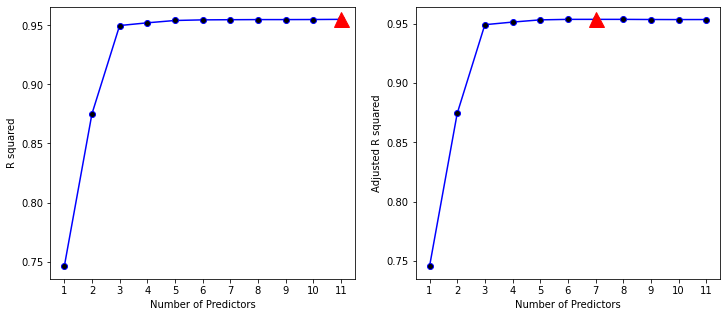

In [2]:
import matplotlib.pyplot as plt

# Create figure
fig = plt.figure(figsize=(12, 5))

# Plot R^2, including maximum 
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(results.loc[:, 'R2'], 'b-',  
         marker='o', markerfacecolor='black')
ax1.plot(np.argmax(results.loc[:, 'R2']), 
         np.max(results.loc[:, 'R2']), 
         'r^', markersize=15)
ax1.set_xlabel('Number of Predictors')
ax1.set_ylabel('R squared')

# Plot R^2 adjusted, including maximum 
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(results.loc[:, 'R2_adj'], 'b-',  
         marker='o', markerfacecolor='black')
ax2.plot(np.argmax(results.loc[:, 'R2_adj']), 
         np.max(results.loc[:, 'R2_adj']), 
         'r^', markersize=15)
ax2.set_xlabel('Number of Predictors')
ax2.set_ylabel('Adjusted R squared')

plt.show()

This is not the case for the values of the adjusted $ \mbox{R}^{2} $. As the **Python**-output reveals, the adjusted $ \mbox{R}^2 $ reaches a maximum for seven predictors, after that the values start decreasing. 

Using the adjusted $ \mbox{R}^2 $ results in the selection of the following regression model that was produced by forward selection 

\begin{align*}
balance
&=\beta_{0}+\beta_{1}\cdot income +\beta_{2}\cdot limit +\beta_{3}\cdot rating +\beta_{4}\cdot cards \\
&\quad+\beta_{5}\cdot age +\beta_{6}\cdot gender +\beta_{7}\cdot student +\epsilon
\end{align*}

### Linear Model Selection Example 2.4
The left-hand panel displays the AIC, the right hand panel the BIC.

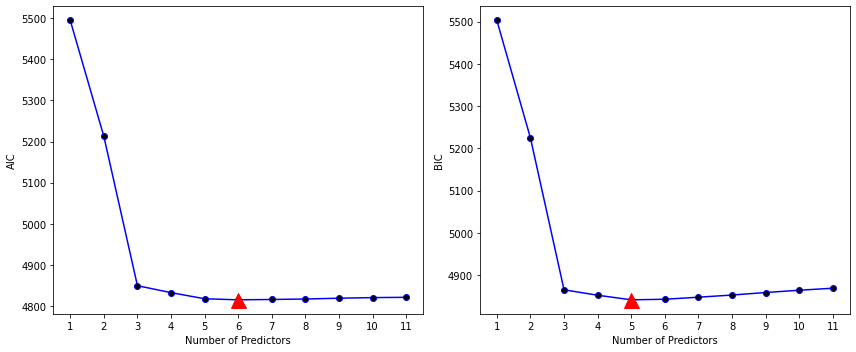

In [3]:
# Create figure
fig = plt.figure(figsize = (12, 5))

# Plot AIC
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(results.loc[:, 'AIC'], 'b-', 
         marker='o', markerfacecolor='black')
ax1.plot(np.argmin(results.loc[:, 'AIC']), 
         np.min(results.loc[:, 'AIC']), 
         'r^', markersize=15)
ax1.set_ylabel('AIC')
ax1.set_xlabel('Number of Predictors')


# Plot BIC
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(results.loc[:, 'BIC'], 'b-',  
         marker='o', markerfacecolor='black')
ax2.plot(np.argmin(results.loc[:, 'BIC']), 
         np.min(results.loc[:, 'BIC']), 
         'r^', markersize=15)
ax2.set_xlabel('Number of Predictors')
ax2.set_ylabel('BIC')

plt.tight_layout()
plt.show()

Note that we have to add 1 to the index of the minimum value, as the index starts at 0, whereas the number of predictors starts at 1.

According to the AIC criterion, the best among all models produced by forward stepwise selection contains six predictor variables. 

In [4]:
print(np.argmin(results.loc[:, 'AIC']) + 1)

6


The (last) **Python**-output of displays the six predictors of the best model produced by forward selection.
\begin{align*}
balance
&=\beta_{0}+\beta_{1}\cdot income +\beta_{2}\cdot limit +\beta_{3}\cdot rating +\beta_{4}\cdot cards \\
&\quad+\beta_{5}\cdot age +\beta_{6}\cdot student +\epsilon
\end{align*}


### Linear Model Selection Example 2.5

If we want to find the best among all models  produced by stepwise forward selection, that is, if we want to identify the most appropriate number of predictors on the basis of the AIC, we only have to repeat the known procedure, for the number of Predictors. Note that the parameter *scoreby* is now set to AIC.

In [1]:
import pandas as pd
import numpy as np
from LMS_def import *

# Load data
df = pd.read_csv('Linear Model Selection/data/Credit.csv')

# Convert Categorical variables
df = pd.get_dummies(data=df, drop_first=True, 
                    prefix=('Gender_', 'Student_', 
                            'Married_', 'Ethnicity_'))

x_full = df.drop(columns='Balance')
y = df['Balance']

results = pd.DataFrame(data={'Best_Pred': [], 'AIC':[]})

# Define the empty predictor
x0 = [np.zeros(len(y))]

x = x0
x_red = x_full.copy()

for i in range(x_full.shape[1]):
    results_i, best_i = add_one(x_red, x, y, scoreby='AIC')
    
    # Update the empty predictor with the best predictor
    x = np.concatenate((x, [df[best_i]]))

    # Remove the chosen predictor from the list of options
    x_red = x_red.drop(columns=best_i)

    # Save results 
    results.loc[i, 'Best_Pred'] = best_i
    results.loc[i, 'AIC'] = results_i['AIC'].min()
    
print('Best Predictors and corresponding AIC:\n', results, 
      '\n\nThe best model thus contains', 
      results['AIC'].argmin() + 1, ' predictors')

Best Predictors and corresponding AIC:
                Best_Pred          AIC
0                 Rating  5494.781548
1                 Income  5212.557085
2           Student__Yes  4849.386992
3                  Limit  4832.524008
4                  Cards  4817.666820
5                    Age  4815.038963
6         Gender__Female  4815.900560
7             Unnamed: 0  4817.004037
8       Ethnicity__Asian  4818.286694
9           Married__Yes  4819.562597
10  Ethnicity__Caucasian  4820.935924
11             Education  4822.448073 

The best model thus contains 6  predictors


### Linear Model Selection Example 2.6

The right-hand panel displays the BIC for the **Credit** data set. For instance, the BIC values result from subtracting the BIC of the null model. 

Based on the BIC values displayed in the **Python**-output, we conclude that the best model produced by forward stepwise selection contains five predictor variables. 


The **Python**-output in the previous example shows that the best model produced by forward stepwise selection and containing five predictors is given by
\begin{align*}
 balance
&=\beta_{0}+\beta_{1}\cdot income +\beta_{2}\cdot limit +\beta_{3}\cdot rating +\beta_{4}\cdot cards \\
&\quad+\beta_{5}\cdot student +epsilon
\end{align*}

In [1]:
import pandas as pd
import numpy as np
from LMS_def import *

# Load data
df = pd.read_csv('Linear Model Selection/data/Credit.csv')

# Convert Categorical variables
df = pd.get_dummies(data=df, drop_first=True, 
                    prefix=('Gender_', 'Student_', 
                            'Married_', 'Ethnicity_'))

x_full = df.drop(columns='Balance')
y = df['Balance']

results = pd.DataFrame(data={'Best_Pred': [], 'BIC':[]})

# Define the empty predictor
x0 = [np.zeros(len(y))]

x = x0
x_red = x_full.copy()

for i in range(x_full.shape[1]):
    results_i, best_i = add_one(x_red, x, y, scoreby='BIC')
    
    # Update the empty predictor with the best predictor
    x = np.concatenate((x, [df[best_i]]))

    # Remove the chosen predictor from the list of options
    x_red = x_red.drop(columns=best_i)

    # Save results 
    results.loc[i, 'Best_Pred'] = best_i
    results.loc[i, 'BIC'] = results_i['BIC'].min()
    
print('Best Predictors and corresponding BIC:\n', results, 
      '\n\nThe best model thus contains', 
      results['BIC'].argmin() + 1, ' predictors')

Best Predictors and corresponding BIC:
                Best_Pred          BIC
0                 Rating  5502.764477
1                 Income  5224.531479
2           Student__Yes  4865.352851
3                  Limit  4852.481331
4                  Cards  4841.615607
5                    Age  4842.979215
6         Gender__Female  4847.832276
7             Unnamed: 0  4852.927218
8       Ethnicity__Asian  4858.201340
9           Married__Yes  4863.468707
10  Ethnicity__Caucasian  4868.833498
11             Education  4874.337112 

The best model thus contains 5  predictors


If we want to identify the best model  by *backward stepwise selection*, then we can use the same procedure as before:

In [2]:
results = pd.DataFrame(data={'Worst_Pred': [], 'BIC':[]})

# Define the full predictor
x = x_full.copy()

for i in range(x_full.shape[1]):
    results_i, worst_i = drop_one(x, y, scoreby='BIC')
    
    # Update the empty predictor with the best predictor
    x = x.drop(columns=worst_i)

    # Save results 
    results.loc[i, 'Worst_Pred'] = worst_i
    results.loc[i, 'BIC'] = results_i['BIC'].min()
    
print('Worst Predictors and corresponding BIC:\n', results, 
      '\n\nThe best model thus contains', 
      x_full.shape[1] - results['BIC'].argmin(), ' predictors')

Worst Predictors and corresponding BIC:
               Worst_Pred          BIC
0              Education  4868.833498
1   Ethnicity__Caucasian  4863.468707
2           Married__Yes  4858.201340
3       Ethnicity__Asian  4852.927218
4             Unnamed: 0  4847.832276
5         Gender__Female  4842.979215
6                    Age  4841.615607
7                 Rating  4840.658660
8                  Cards  4873.759072
9           Student__Yes  5237.176925
10                Income  5507.965562
11                 Limit  6044.702777 

The best model thus contains 5  predictors
